In [1]:
import math
import random
import time
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np

#Genetic algorithm code

In [2]:
class Solution:
    def __init__(self, solution, fitness):
        self.solution = solution
        self.fitness = fitness
        self.modified = True


In [3]:
params = {
    'population_size': 100,        # Size of the population
    'num_iterations': 100,         # Number of iterations (generations)
    'crossover_probability': 0.5,  # Probability of crossover (50% in decimal form)
    'mutation_probability': 0.5,   # Probability of mutation (50% in decimal form)
    'tournament_size': 5,          # Size of the tournament for selection
    'optimization': 'min',         # Optimization type ('min' for minimization, 'max' for maximization)
    'log': False                   # Enable logging (True/False)
}


In [4]:
def plot_with_std(x, means, std_devs, elite_fitness, log=False):
    """
    Plots the mean and standard deviations of the fitness scores.

    Parameters:
    x (list or array): Values for the x-axis (iterations).
    means (list or array): Mean fitness values.
    std_devs (list or array): Standard deviations of the fitness values.
    elite_fitness (list or array): Best fitness values for each iteration.
    log (bool): If True, use logarithmic scale for the y-axis.
    """
    # Convert inputs to numpy arrays for easier manipulation
    x = np.array(x)
    means = np.array(means)
    std_devs = np.array(std_devs)

    # Calculate upper and lower bounds for standard deviations
    upper = means + std_devs
    lower = means - std_devs

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the mean fitness as a solid line
    plt.plot(x, means, label="Mean Fitness", color="blue", linestyle="-")

    # Plot the standard deviations as dashed lines
    plt.plot(x, upper, label="Mean + Std Dev", color="red", linestyle="--")
    plt.plot(x, lower, label="Mean - Std Dev", color="green", linestyle="--")

    # Plot the best fitness values (elite fitness)
    plt.plot(x, elite_fitness, label="Elite Fitness", color="orange", linestyle="-")

    # Apply logarithmic scale if specified
    if log:
        plt.yscale("log")

    # Add labels, legend, and title
    plt.xlabel("Iterations")
    plt.ylabel("Average Fitness")
    plt.legend()
    plt.title("Mean and Standard Deviation of Fitness Scores")

    # Display the plot
    plt.show()


In [5]:
def genetic_algorithm(population_generator, evaluate_fitness, genetic_operations, args, verbose=False, plot=False):
    """
    Genetic Algorithm implementation.

    Parameters:
    population_generator (function): Function to generate the initial population.
    evaluate_fitness (function): Function to evaluate the fitness of an individual.
    genetic_operations (function): Function to apply genetic operations (crossover, mutation).
    args (dict): Dictionary of arguments and parameters for the algorithm.
    verbose (bool): If True, prints progress information.
    plot (bool): If True, plots the fitness progression.

    Returns:
    tuple: Final population, best solution, and best fitness value.
    """

    # Helper function to get the best individual based on optimization type
    def get_best(population, key, args):
        if args['optimization'] == 'max':
            return max(population, key=key)
        else:
            return min(population, key=key)

    # Generate initial population
    population = population_generator(args)

    # Evaluate the fitness of each individual in the population
    fit_means = []
    fit_stds = []
    elite_fitnesses = []

    for individual in population:
        individual.fitness = evaluate_fitness(individual, args)

    # Get the elite (best individual) from the initial population
    elite = deepcopy(get_best(population, lambda x: x.fitness, args))

    iteration = 0
    # Main loop of the genetic algorithm
    while iteration < args['num_iterations'] and not (
        args.get('early_stop', False) and
        args['optimization'] == 'min' and
        elite.fitness == 0
    ):
        if verbose:
            print(f"Iteration {iteration + 1}")
            print(f"Best fitness: {elite.fitness}")

        # Apply genetic operations to generate the new population
        population = genetic_operations(population, elite, args)

        # Evaluate the fitness of modified individuals
        for individual in population:
            if individual.modified:
                individual.modified = False
                individual.fitness = evaluate_fitness(individual, args)

        # Update the elite individual
        elite = deepcopy(get_best(population+[elite], lambda x: x.fitness, args))

        # Collect statistics for plotting
        fitness_values = list(map(lambda x: x.fitness, population))
        fit_means.append(np.mean(fitness_values))
        fit_stds.append(np.std(fitness_values))
        elite_fitnesses.append(elite.fitness)

        iteration += 1

    # Print the final results if verbose mode is enabled
    if verbose:
        print(f"Best solution: {elite.solution}")
        print(f"Best fitness: {elite.fitness}")

    # Plot the fitness progression if plotting is enabled
    if plot:
        plot_with_std(range(1, iteration + 1), fit_means, fit_stds, elite_fitnesses, log=args.get('log', False))

    # Return the final population, best solution, and best fitness value
    return population, elite.solution, elite.fitness


#Main code

In [6]:
colors = ['red','orange','brown','light_brown','green','light_green','pink','blue','light_blue','purple','yellow']

In [7]:
def is_valid_move(flask1, flask2, verbose=False):
    """
    Checks if the move from flask1 to flask2 is valid.

    Parameters:
    flask1 (list): Source flask.
    flask2 (list): Target flask.
    verbose (bool): If True, prints debug information.

    Returns:
    bool: True if the move is valid, False otherwise.
    """
    if len(flask1) == 0:
        if verbose:
            print("Flask1 is empty.")
        return False
    if len(flask2) == 4:
        if verbose:
            print("Flask2 is full.")
        return False
    if len(flask2) > 0 and flask1[0] != flask2[0]:
        if verbose:
            print("Flask colors do not match.")
        return False
    return True


def move_flask(flask1, flask2):
    """
    Moves elements from flask1 to flask2 if the move is valid.

    Parameters:
    flask1 (list): Source flask.
    flask2 (list): Target flask.

    Returns:
    tuple: Updated flasks (flask1, flask2) or (-1, -1) if the move is invalid.
    """
    if len(flask1) == 0 or len(flask2) == 4 or (len(flask2) > 0 and flask1[0] != flask2[0]):
        return -1, -1

    # Transfer the top color from flask1 to flask2
    first_color = flask1.pop(0)
    flask2.insert(0,first_color)

    # Continue transferring if the colors match and flask2 is not full
    while len(flask1) > 0 and flask1[0] == first_color and len(flask2) < 4:
        first_color = flask1.pop(0)
        flask2.insert(0,first_color)

    return flask1, flask2


def calculate_entropy(flask, colors):
    """
    Calculates the entropy of a flask based on color continuity and impurity.

    Parameters:
    flask (list): Flask to evaluate.
    colors (list): List of possible colors.

    Returns:
    float: Entropy value of the flask.
    """
    if len(flask) == 0:
        return 0

    max_connect_factor = 1
    for i in range(len(flask)):
        j = i + 1
        connect_factor = 1
        while j < len(flask) and flask[i] == flask[j]:
            connect_factor += 1
            j += 1
        max_connect_factor = max(max_connect_factor, connect_factor)

    impurity_factor = len(set(flask))
    return (impurity_factor ** 2) / max_connect_factor


def evaluate_flasks(flasks):
    """
    Evaluates the fitness of the current state of all flasks.

    Parameters:
    flasks (list): List of flasks to evaluate.

    Returns:
    float: Fitness score (lower is better).
    """
    total_entropy = sum(calculate_entropy(f, colors) for f in flasks)
    non_void_flasks = [f for f in flasks if len(f) > 0]
    max_size = max(len(f) for f in non_void_flasks)
    # Check if the puzzle is solved
    for flask in flasks:
        if len(set(flask)) > 1:
            return total_entropy / len(non_void_flasks)
        if not (len(flask) == 0 or len(flask) == max_size):
            return total_entropy / len(non_void_flasks)

    return 0  # Puzzle solved


def solution_to_flasks(solution, flasks):
    """
    Applies a solution (sequence of moves) to the given flasks.

    Parameters:
    solution (list): List of moves (tuples with source and target indices).
    flasks (list): Current state of the flasks.

    Returns:
    list: Updated flasks after applying the solution, or an empty list if invalid move.
    """
    flasks_copy = deepcopy(flasks)
    for move in solution:
        move_flask(flasks_copy[move[0]], flasks_copy[move[1]])
        if flasks_copy[move[0]] == -1:
            return []
    return flasks_copy





In [8]:
def get_neighbour_moves(solution, flasks):
    """
    Generates a list of valid neighbor moves based on the current solution.

    Parameters:
    solution (list): Current solution (sequence of moves).
    flasks (list): Current state of the flasks.

    Returns:
    list: List of valid moves (each move is represented as [source_index, target_index]).
    """
    # Get the current flask state after applying the solution
    flask_copy = solution_to_flasks(solution, flasks)
    valid_moves = []

    # Iterate over all pairs of flasks
    for i in range(len(flask_copy)):
        for j in range(len(flask_copy)):
            # Skip if the source and target are the same or if the move is invalid
            if i == j or not is_valid_move(flask_copy[i], flask_copy[j]):
                continue
            # Add the valid move to the list
            valid_moves.append([i, j])

    return valid_moves


In [9]:
def generate_random_solution(args):
    """
    Generates a random solution by selecting valid moves up to a given size.

    Parameters:
    args (dict): Dictionary of algorithm parameters, including the flask data and solution size.

    Returns:
    list: A random solution represented as a sequence of moves.
    """
    flasks = deepcopy(args['data'])  # Copy the initial flask configuration
    solution_size = args['solution_size']
    solution = []

    # Get the initial list of valid neighbor moves
    neighbors = get_neighbour_moves(solution, flasks)

    # Continue selecting random valid moves until reaching the solution size limit
    while len(neighbors) > 0 and len(solution) < solution_size:
        move = random.choice(neighbors)
        solution.append(move)
        neighbors = get_neighbour_moves(solution, flasks)

    return solution


def generate_population(args):
    """
    Generates the initial population of solutions for the genetic algorithm.

    Parameters:
    args (dict): Dictionary of algorithm parameters, including population size and optimization type.

    Returns:
    list: List of solution objects representing the initial population.
    """
    population_size = args['population_size']
    population = []

    # Generate each individual in the population
    for _ in range(population_size):
        random_solution = generate_random_solution(args)
        individual = Solution(random_solution, 0)

        # Initialize fitness based on the optimization type
        if args['optimization'] == 'max':
            individual.fitness = float('-inf')
        else:
            individual.fitness = float('inf')

        population.append(individual)

    return population


In [10]:
def evaluate_solution(solution, args):
    """
    Evaluates the fitness of a given solution based on the current flask configuration.

    Parameters:
    solution (Solution): The solution object containing the sequence of moves.
    args (dict): Dictionary of algorithm parameters, including the flask data.

    Returns:
    float: The fitness score of the solution. Returns 100 if the solution is invalid.
    """
    # Apply the solution to the flask configuration
    flasks = solution_to_flasks(solution.solution, args['data'])

    # If the resulting flask configuration is invalid, return a high fitness score (penalty)
    if not flasks:
        return 100

    # Otherwise, evaluate the fitness based on the flask entropy
    return evaluate_flasks(flasks)


In [11]:
def genetic_operations(population, elite, args):
    """
    Applies genetic operations (selection, crossover, mutation) to generate a new population.

    Parameters:
    population (list): List of current solution objects.
    elite (Solution): The best solution from the current population.
    args (dict): Dictionary of algorithm parameters, including probabilities and optimization type.

    Returns:
    list: New population after applying genetic operations.
    """
    new_population = []

    # Selection (Tournament Selection)
    for _ in range(len(population)):
        tournament = random.sample(population, args['tournament_size'])
        if args['optimization'] == 'max':
            selected = deepcopy(max(tournament, key=lambda x: x.fitness))
        else:
            selected = deepcopy(min(tournament, key=lambda x: x.fitness))
        new_population.append(selected)

    # Crossover (Single-point crossover)
    for i in range(0, len(new_population), 2):
        if random.randint(0, 100) < args['crossover_probability']:
            parent1, parent2 = new_population[i].solution, new_population[i + 1].solution
            child1, child2 = deepcopy(parent1), deepcopy(parent2)

            # Randomly select a crossover point
            crossover_point = random.randint(1, len(parent1) - 1)

            # Create children by exchanging segments
            child1 = parent1[:crossover_point] + parent2[crossover_point:]
            child2 = parent2[:crossover_point] + parent1[crossover_point:]

            # Update solutions and mark them as modified
            new_population[i].solution = child1
            new_population[i + 1].solution = child2
            new_population[i].modified = True
            new_population[i + 1].modified = True

    # Mutation (Random mutation of individuals)
    for individual in new_population:
        if random.randint(0, 100) < args['mutation_probability']:
            if random.random() < 0.5:
                # Remove random genes (deletion mutation)
                mutation_strength = random.randint(1, 3)
                for _ in range(mutation_strength):
                    if len(individual.solution) == 0:
                        break
                    individual.solution.pop()

            else:
                # Add new genes (insertion mutation)
                mutation_strength = random.randint(1, 3)
                for _ in range(mutation_strength):
                    neighbors = get_neighbour_moves(individual.solution, args['data'])
                    if len(neighbors) == 0:
                        continue
                    move = random.choice(neighbors)
                    individual.solution.append(move)

            # Mark the individual as modified
            individual.modified = True

    return new_population


##Test 1

In [12]:
flasks = [
    ['yellow','green','green','blue'],
    ['orange','blue','green','blue'],
    ['red','green','orange','red'],
    ['red','blue','orange','yellow'],
    ['red','yellow','orange','yellow'],
    [],
    []
]

In [13]:
params = {
    'population_size': 100,          # Size of the population
    'num_iterations': 100,           # Number of iterations (generations)
    'crossover_probability': 50,     # Probability of crossover (in percentage)
    'mutation_probability': 30,      # Probability of mutation (in percentage)
    'tournament_size': 5,            # Size of the tournament for selection
    'optimization': 'min',           # Type of optimization ('min' for minimization, 'max' for maximization)
    'data': flasks,                  # Initial state of the flasks
    'colors': colors,                # List of available colors
    'log': False,                    # Use logarithmic scale for the y-axis in the plot (True/False)
    'solution_size': 2,              # Maximum size of the solution (number of moves)
    'early_stop': True               # Enable early stopping if the solution is found
}


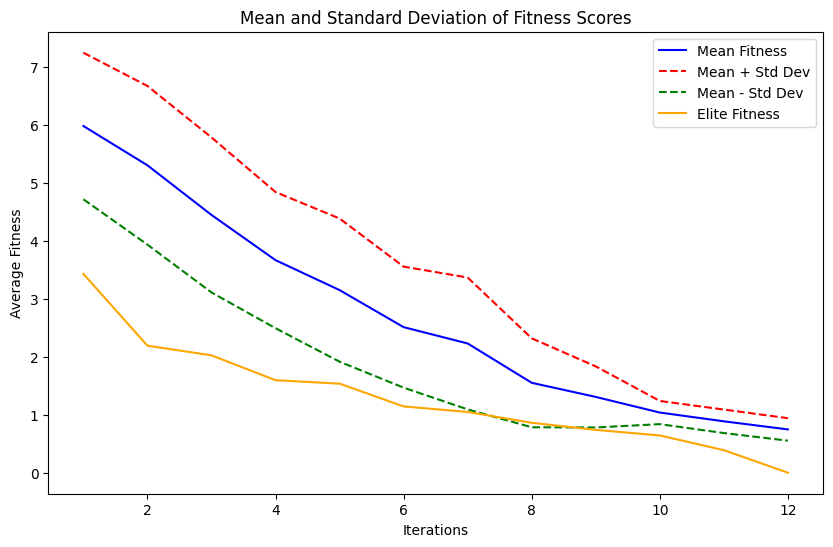

Best fitness score: 0
Best solution: 
[[3, 6], [1, 6], [1, 5], [3, 1], [2, 6], [3, 5], [4, 6], [0, 4], [2, 0], [2, 5], [2, 6], [5, 2], [0, 5], [4, 3], [4, 2], [1, 0], [5, 1], [3, 4], [1, 3], [5, 3], [2, 5], [0, 1], [5, 0]]
Flasks after the moves:
[['orange', 'orange', 'orange', 'orange'], ['blue', 'blue', 'blue', 'blue'], [], ['green', 'green', 'green', 'green'], ['yellow', 'yellow', 'yellow', 'yellow'], [], ['red', 'red', 'red', 'red']]


In [14]:
# Run the genetic algorithm
population, best_solution, best_fitness = genetic_algorithm(
    generate_population,  # Function to generate the initial population
    evaluate_solution,    # Function to evaluate the fitness of a solution
    genetic_operations,   # Function to apply genetic operations (selection, crossover, mutation)
    params,               # Dictionary of parameters for the algorithm
    verbose=False,        # Disable verbose output
    plot=True             # Enable plotting of the fitness progression
)

# Print the best fitness score found
print(f"Best fitness score: {best_fitness}")
print(f"Best solution: \n{best_solution}")
print(f'Flasks after the moves:')
print(solution_to_flasks(best_solution,flasks))

##Test 2

In [15]:
flasks2 = [
    ['orange','red','blue','blue'],
    ['yellow','green','red','blue'],
    ['green','orange','yellow','blue'],
    ['red','green','orange','yellow'],
    ['orange','red','green','yellow'],
    [],
    []
]

In [16]:
params = {
    'population_size': 100,          # Size of the population
    'num_iterations': 100,           # Number of iterations (generations)
    'crossover_probability': 50,     # Probability of crossover (in percentage)
    'mutation_probability': 30,      # Probability of mutation (in percentage)
    'tournament_size': 5,            # Size of the tournament for selection
    'optimization': 'min',           # Type of optimization ('min' for minimization, 'max' for maximization)
    'data': flasks2,                 # Initial state of the flasks
    'colors': colors,                # List of available colors
    'log': False,                    # Use logarithmic scale for the y-axis in the plot (True/False)
    'solution_size': 4,              # Maximum size of the solution (number of moves)
    'early_stop': True               # Enable early stopping if the solution is found
}


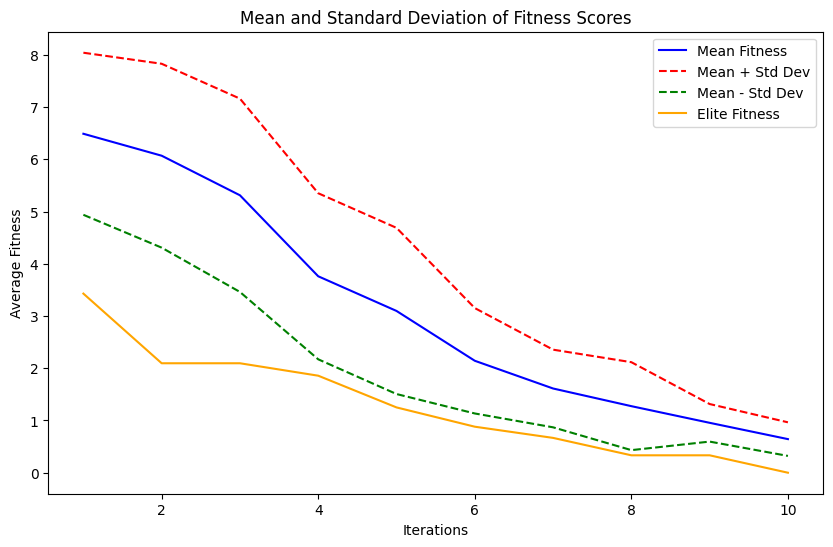

Best fitness score: 0
Best solution: 
[[2, 5], [1, 6], [4, 2], [3, 4], [3, 5], [2, 3], [6, 2], [1, 5], [1, 6], [4, 6], [4, 5], [2, 4], [1, 2], [2, 1], [0, 2], [3, 2], [0, 6], [4, 3], [0, 4], [5, 0], [2, 5], [4, 1]]
Flasks after the moves:
[['green', 'green', 'green', 'green'], ['blue', 'blue', 'blue', 'blue'], [], ['yellow', 'yellow', 'yellow', 'yellow'], [], ['orange', 'orange', 'orange', 'orange'], ['red', 'red', 'red', 'red']]


In [17]:
# Run the genetic algorithm
population, best_solution, best_fitness = genetic_algorithm(
    generate_population,  # Function to generate the initial population
    evaluate_solution,    # Function to evaluate the fitness of a solution
    genetic_operations,   # Function to apply genetic operations (selection, crossover, mutation)
    params,               # Dictionary of parameters for the algorithm
    verbose=False,        # Disable verbose output
    plot=True             # Enable plotting of the fitness progression
)

# Print the best fitness score found
print(f"Best fitness score: {best_fitness}")
print(f"Best solution: \n{best_solution}")
print(f'Flasks after the moves:')
print(solution_to_flasks(best_solution,flasks2))

##Tests 3

In [18]:
flasks3 = [
    ['orange','light_green','light_green','light_brown'],
    ['red','light_brown','light_blue','light_brown'],
    ['orange','pink','orange','brown'],
    ['red','green','green','brown'],
    ['light_green','blue','light_brown','pink'],
    ['blue','pink','green','pink'],
    ['light_blue','blue','purple','green'],
    ['orange','red','purple','blue'],
    ['purple','light_blue','purple','yellow'],
    ['brown','brown','light_blue','yellow'],
    ['light_green','red','yellow','yellow'],
    [],
    []
]

In [19]:
params = {
    'population_size': 1000,          # Size of the population
    'num_iterations': 100,           # Number of iterations (generations)
    'crossover_probability': 50,     # Probability of crossover (in percentage)
    'mutation_probability': 30,      # Probability of mutation (in percentage)
    'tournament_size': 5,            # Size of the tournament for selection
    'optimization': 'min',           # Type of optimization ('min' for minimization, 'max' for maximization)
    'data': flasks3,                 # Initial state of the flasks
    'colors': colors,                # List of available colors
    'log': False,                    # Use logarithmic scale for the y-axis in the plot (True/False)
    'solution_size': 2,              # Maximum size of the solution (number of moves)
    'early_stop': True               # Enable early stopping if the solution is found
}


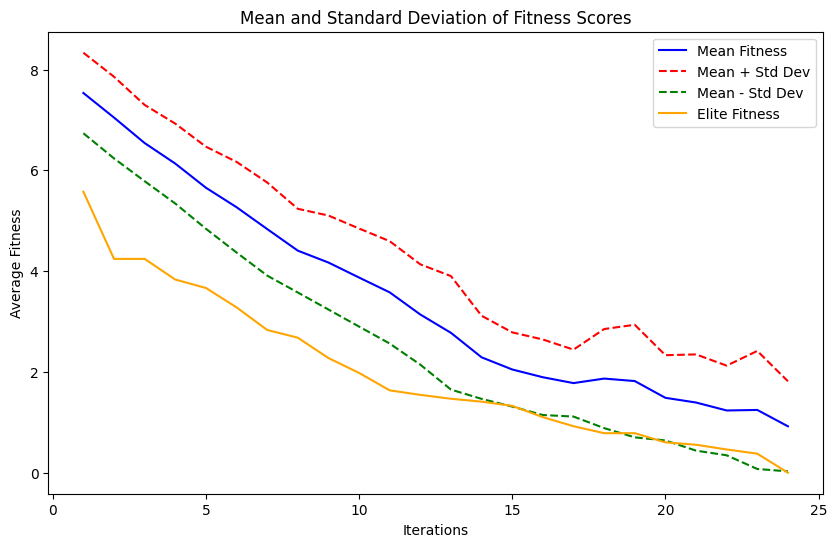

Best fitness score: 0
Best solution: 
[[10, 11], [7, 12], [4, 11], [1, 10], [5, 4], [10, 12], [3, 7], [2, 11], [0, 12], [10, 0], [0, 11], [1, 0], [2, 12], [5, 2], [3, 5], [6, 1], [9, 3], [1, 9], [1, 0], [4, 1], [6, 1], [0, 4], [4, 0], [8, 6], [2, 4], [12, 2], [9, 8], [2, 12], [3, 2], [8, 3], [6, 8], [5, 6], [3, 9], [9, 3], [4, 5], [7, 4], [10, 4], [8, 7], [10, 9], [7, 10], [8, 10], [7, 1], [9, 8]]
Flasks after the moves:
[['light_brown', 'light_brown', 'light_brown', 'light_brown'], ['blue', 'blue', 'blue', 'blue'], ['brown', 'brown', 'brown', 'brown'], ['light_blue', 'light_blue', 'light_blue', 'light_blue'], ['red', 'red', 'red', 'red'], ['pink', 'pink', 'pink', 'pink'], ['green', 'green', 'green', 'green'], [], ['yellow', 'yellow', 'yellow', 'yellow'], [], ['purple', 'purple', 'purple', 'purple'], ['light_green', 'light_green', 'light_green', 'light_green'], ['orange', 'orange', 'orange', 'orange']]


In [20]:
# Run the genetic algorithm
population, best_solution, best_fitness = genetic_algorithm(
    generate_population,  # Function to generate the initial population
    evaluate_solution,    # Function to evaluate the fitness of a solution
    genetic_operations,   # Function to apply genetic operations (selection, crossover, mutation)
    params,               # Dictionary of parameters for the algorithm
    verbose=False,        # Disable verbose output
    plot=True             # Enable plotting of the fitness progression
)

# Print the best fitness score found
print(f"Best fitness score: {best_fitness}")
print(f"Best solution: \n{best_solution}")
print(f'Flasks after the moves:')
print(solution_to_flasks(best_solution,flasks3))